In [13]:
from datasets import load_dataset

dataset_fin = load_dataset("zeroshot/twitter-financial-news-sentiment")
train_dataset = dataset_fin['train']
test_dataset = dataset_fin['validation']

In [14]:
from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")

In [15]:
def preprocess_function(examples):
    return tokenizer(examples["text"], truncation=True, padding="max_length", max_length=128)

tokenized_train = train_dataset.map(preprocess_function, batched=True)
tokenized_test = test_dataset.map(preprocess_function, batched=True)

In [16]:
true_labels = tokenized_test["label"]

In [17]:
from transformers import DataCollatorWithPadding

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

In [18]:
import evaluate

accuracy = evaluate.load("accuracy")

In [19]:
import numpy as np

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return accuracy.compute(predictions=predictions, references=labels)

In [20]:
id2label = {0: "BEARISH", 1: "BULLISH", 2: "NEUTRAL"}
label2id = {"BEARISH": 0, "BULLISH": 1, "NEUTRAL": 2}

In [21]:
from transformers import AutoModelForSequenceClassification, TrainingArguments, Trainer

model = AutoModelForSequenceClassification.from_pretrained(
    "distilbert/distilbert-base-uncased", num_labels=3, id2label=id2label, label2id=label2id
)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert/distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [25]:
training_args = TrainingArguments(
    output_dir="trained_fin_model",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=3,
    weight_decay=0.01,
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    push_to_hub=False,
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_test,
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

trainer.train()

  0%|          | 0/1791 [00:00<?, ?it/s]

{'loss': 0.1577, 'grad_norm': 3.4203202724456787, 'learning_rate': 1.4416527079843662e-05, 'epoch': 0.84}


  0%|          | 0/150 [00:00<?, ?it/s]

{'eval_loss': 0.45477375388145447, 'eval_accuracy': 0.8760469011725294, 'eval_runtime': 12.1975, 'eval_samples_per_second': 195.778, 'eval_steps_per_second': 12.298, 'epoch': 1.0}
{'loss': 0.0917, 'grad_norm': 2.404296398162842, 'learning_rate': 8.833054159687326e-06, 'epoch': 1.68}


  0%|          | 0/150 [00:00<?, ?it/s]

{'eval_loss': 0.5648341774940491, 'eval_accuracy': 0.8840033500837521, 'eval_runtime': 12.8179, 'eval_samples_per_second': 186.302, 'eval_steps_per_second': 11.702, 'epoch': 2.0}
{'loss': 0.0607, 'grad_norm': 0.016204029321670532, 'learning_rate': 3.2495812395309884e-06, 'epoch': 2.51}


  0%|          | 0/150 [00:00<?, ?it/s]

{'eval_loss': 0.6133782863616943, 'eval_accuracy': 0.8806532663316583, 'eval_runtime': 12.0455, 'eval_samples_per_second': 198.249, 'eval_steps_per_second': 12.453, 'epoch': 3.0}
{'train_runtime': 589.9176, 'train_samples_per_second': 48.531, 'train_steps_per_second': 3.036, 'train_loss': 0.09621307824591163, 'epoch': 3.0}


TrainOutput(global_step=1791, training_loss=0.09621307824591163, metrics={'train_runtime': 589.9176, 'train_samples_per_second': 48.531, 'train_steps_per_second': 3.036, 'total_flos': 948119197089024.0, 'train_loss': 0.09621307824591163, 'epoch': 3.0})

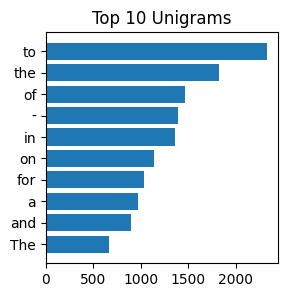

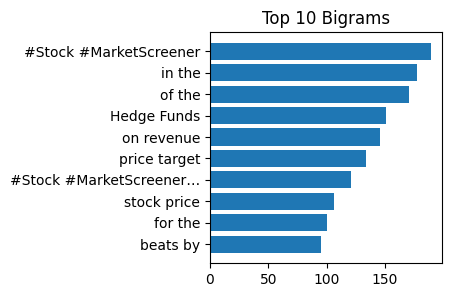

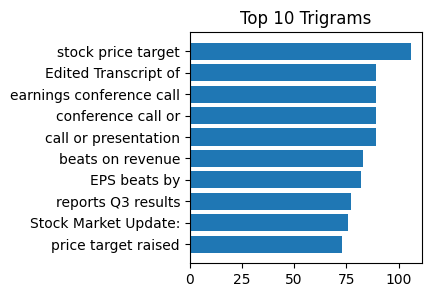

In [23]:
from collections import Counter
from nltk import ngrams
import matplotlib.pyplot as plt

def word_count(texts):
    word_counts = Counter()
    for text in texts:
        word_counts.update(text.split())
    return word_counts

def get_ngrams(texts, n):
    ngram_counts = Counter()
    for text in texts:
        tokens = text.split()
        ngram_counts.update(ngrams(tokens, n))
    return ngram_counts

def plot_ngrams(ngram_counts, title, num=10):
    ngram, count = zip(*ngram_counts.most_common(num))
    ngram = [' '.join(gram) for gram in ngram]
    plt.figure(figsize=(3, 3))
    plt.barh(ngram, count)
    plt.title(title)
    plt.gca().invert_yaxis()
    plt.show()


dataset_fin = dataset_fin.map(preprocess_function, batched=True)

# Analyze word count and n-grams
train_texts = [example['text'] for example in dataset_fin['train']]

train_word_counts = word_count(train_texts)
train_unigrams = get_ngrams(train_texts, 1)
train_bigrams = get_ngrams(train_texts, 2)
train_trigrams = get_ngrams(train_texts, 3)

# Plot top 10 unigrams, bigrams, and trigrams
plot_ngrams(train_unigrams, "Top 10 Unigrams", 10)
plot_ngrams(train_bigrams, "Top 10 Bigrams", 10)
plot_ngrams(train_trigrams, "Top 10 Trigrams", 10)


# Huggingface confusion matrix!!!

  0%|          | 0/299 [00:00<?, ?it/s]

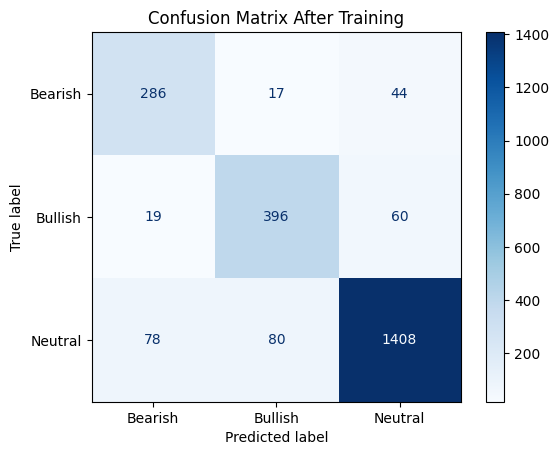

In [24]:

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Preprocess function for tokenization
def preprocess_function(examples):
    return tokenizer(examples["text"], truncation=True, padding=True)

# Function to evaluate model and get predictions
def get_predictions(model, tokenized_dataset):
    # Use Trainer for prediction
    trainer = Trainer(model=model)
    predictions = trainer.predict(tokenized_dataset)
    preds = np.argmax(predictions.predictions, axis=1)
    return preds

# Get predictions after training 
preds_after = get_predictions(model, tokenized_test)


# Compute and plot confusion matrix
def plot_confusion_matrix(true_labels, preds, title):
    cm = confusion_matrix(true_labels, preds, labels=[0, 1, 2])
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Bearish", "Bullish", "Neutral"])
    disp.plot(cmap=plt.cm.Blues)
    plt.title(title)
    plt.show()


# Confusion matrix after training
plot_confusion_matrix(true_labels, preds_after, "Confusion Matrix After Training")

